# 1. MNIST dataset

In this tutorial, we will use `MNIST dataset` to make an algorithm that can distinguish numbers between 1~10.
First, we need to download `MNIST dataset.`

In [49]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


 There are 70,000 data points (i.e., images) in total: 55,000 training data points (mnist.train), 10,000 test data (mnist.test), and 5,000 validation data (mnist.validation).

A MNIST data point has two parts: an image of handwritten digit (`mnist.X.images`), and a corresponding label (`mnist.X.labels`). X can be either `train`, `test`, or `validation`. Each image is `28x28` pixels, which is a array of 784 numbers (i.e., 784-dimensional vector space).

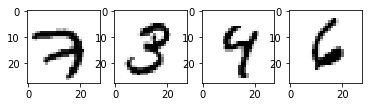

In [50]:
import matplotlib.pyplot as plt
plt.subplot(1,4,1)
plt.imshow(mnist.train.images[0].reshape([28,28]), cmap=plt.get_cmap("Greys"))
plt.subplot(1,4,2)
plt.imshow(mnist.train.images[1].reshape([28,28]), cmap=plt.get_cmap("Greys"))
plt.subplot(1,4,3)
plt.imshow(mnist.train.images[2].reshape([28,28]), cmap = plt.get_cmap("Greys"))
plt.subplot(1,4,4)
plt.imshow(mnist.train.images[3].reshape([28,28]), cmap = plt.get_cmap("Greys"))
plt.show()

# 2. Step-by-step tutorial for building a model for number recognition.

## 2.1 

To set a certain dimensional variable without specific values (i.e., *placeholder*), you use `placeholder.` **It is a value that we'll input when we ask `tensorflow` to run a computation.** To see the benefits of using `placeholder`, see https://www.tensorflow.org/get_started/mnist/beginners.

Here, we create a variable with zero row and 784 columns (784 is the number of features for MNIST dataset).

In [80]:
import tensorflow as tf
x = tf.placeholder(tf.float32, [None, 784])

Here, `None` means that a row dimsenion can be of any length.

Next, we use `Variable` as a modifiable tensor that lives in TensorFlow's graph of interacting operations. For machine learning applications, one generally has the **model parameters** be Variables.

In [81]:
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

`W` has a shape of [784, 10] because it has 784 pixels (features) and 10 numbers (1~10). So, the output of `W*x + b` will be the probability of correspond to the numbers between 1~10.

We use `tf.zeros` to fill `W` and `b` with zeros, but because `W` and `b` are what we are going to learn and thus change, the initial values don't matter much.

In [82]:
y_man = tf.nn.softmax(tf.matmul(x, W) + b)

To implement cross entropy, we need a placeholder for the correct answers:

In [83]:
y_ = tf.placeholder(tf.float32, [None, 10])

And then we can implement the cross-entropy function

In [84]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_*tf.log(y_man), reduction_indices=[1]))

You can write `cross_entropy` from Tensorflow, and then you can rewrite above two lines as follows:

In [85]:
y_tf = tf.matmul(x, W) + b
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_tf, labels=y_))

Note that the difference between `y_man` and `y_tf` is that **`y_man` has `tf.softmax` applied to the regression function `tf.matmul(x,W)+b`, while `y_tf` only has the regression function.** The reason is because `tf.nn.softmax_cross_entropy_with_logits` automatically calculates the softmax activation function applied to the model's prediction (y) to operate cross-entropy between y and the target (y\_), the model's prediction `y`
__should not__ have `softmax` in itself, while when we write cross-entropy function manually, we need to apply softmax activation function to `y` manually as well.

Now, you use `Gradient Descent` to calculate (1) the steepest descent of the loss with respect to each variables, with (2) step length 0.5:

In [86]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

### The above is a short for:
# optimizer = tf.train.GradientDescentOptimizer(0.5)
# train_step = optimizer.minimize(cross_entropy).`

In [87]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict = {x:batch_xs, y_:batch_ys})

IMPORTANT: you need to use `y_` for `feed_dict`, not `y`.

# 3. Evaluating our model

In [88]:
correct_prediction = tf.equal(tf.argmax(y_man, 1), tf.argmax(y_, 1))

In [89]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x:mnist.test.images, y_:mnist.test.labels}))

0.9152


# 4. Side-by-side comparison between cross entropy from library and manual script

***Note*** <br>
Use of cross-entropy from tensorflow library: <https://www.tensorflow.org/get_started/mnist/pros> <br>
Making cross-entropy algorithm manually: <https://www.tensorflow.org/get_started/mnist/beginners>

In [101]:
import tensorflow as tf
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y_ = tf.placeholder(tf.float32, [None, 10])

sess = tf.InteractiveSession()

In [107]:
#Manual cross entropy
y = tf.nn.softmax(tf.matmul(x, W) + b)
cross_entropy_man = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy_man)
tf.global_variables_initializer().run()
for _ in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9173


In [108]:
#Cross entropy from tensorflow library
y = tf.matmul(x, W) + b
cross_entropy_lib = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy_lib)
tf.global_variables_initializer().run()
for _ in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9186


# IMPORTANT NOTE: EASY MISTAKES TO MAKE

If you mistakenly apply `softmax` function to `y` while you use `soft_max_cross_entropy`, then you'll get much smaller accuracy rate:

In [110]:
# Wrong version
y = tf.nn.softmax(tf.matmul(x, W) + b)
cross_entropy_lib = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy_lib)
tf.global_variables_initializer().run()
for _ in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9069
